In [ ]:
!pip install --quiet librosa scikit-learn python_speech_features soundfile
!pip install datasets==3.6.0


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, Audio
from sklearn.metrics import accuracy_score, classification_report
import python_speech_features as psf
import librosa
import soundfile as sf
from io import BytesIO

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [ ]:
TARGET_SR = 16000
N_MFCC = 26

# Load dataset WITH automatic audio decoding
raw_ds = load_dataset("DarshanaS/IndicAccentDb")
full = raw_ds["train"]

label_names = full.features["label"].names
print("Labels:", label_names)

# Create test split (using same seed as training)
splits = full.train_test_split(test_size=0.15, stratify_by_column="label", seed=42)
test_hf = splits["test"]

print("Test set size:", len(test_hf))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

IndicAccentDB.zip:   0%|          | 0.00/3.20G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8116 [00:00<?, ? examples/s]

Labels: ['andhra_pradesh', 'gujrat', 'jharkhand', 'karnataka', 'kerala', 'tamil']
Test set size: 1218


In [ ]:
def ensure_mono_resampled(audio_dict, target_sr=TARGET_SR):
    """Convert audio to mono and resample"""
    wav = np.array(audio_dict["array"], dtype=np.float32)
    sr = audio_dict["sampling_rate"]

    # Convert to mono if stereo
    if wav.ndim > 1:
        wav = wav.mean(axis=0)

    # Resample if needed
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)

    return wav, target_sr

def extract_mfcc(wav, sr=TARGET_SR, n_mfcc=N_MFCC):
    """Extract MFCC features"""
    mfcc = psf.mfcc(
        signal=wav,
        samplerate=sr,
        numcep=n_mfcc,
        nfilt=n_mfcc,
        winlen=0.025,
        winstep=0.01,
    )
    # Normalize
    mfcc = (mfcc - mfcc.mean(axis=0)) / (mfcc.std(axis=0) + 1e-9)
    return mfcc.astype(np.float32)


In [ ]:
class MFCCDataset(Dataset):
    def __init__(self, hf_dataset, n_mfcc=N_MFCC, max_len=400):
        self.ds = hf_dataset
        self.n_mfcc = n_mfcc
        self.max_len = max_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        audio = row["audio"]
        wav, sr = ensure_mono_resampled(audio)
        mfcc = extract_mfcc(wav, sr, n_mfcc=self.n_mfcc)

        # Ensure correct feature dimensions
        if mfcc.shape[1] > self.n_mfcc:
            mfcc = mfcc[:, :self.n_mfcc]
        elif mfcc.shape[1] < self.n_mfcc:
            pad_feat = np.zeros((mfcc.shape[0], self.n_mfcc - mfcc.shape[1]), dtype=np.float32)
            mfcc = np.hstack([mfcc, pad_feat])

        # Pad/truncate time dimension
        if mfcc.shape[0] < self.max_len:
            pad = np.zeros((self.max_len - mfcc.shape[0], self.n_mfcc), dtype=np.float32)
            mfcc = np.vstack([mfcc, pad])
        else:
            mfcc = mfcc[:self.max_len]

        x = torch.from_numpy(mfcc).transpose(0, 1).float()
        y = int(row["label"])
        return x, y


In [ ]:
class MFCCCNN(nn.Module):
    def __init__(self, n_mfcc=N_MFCC, n_classes=6):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_mfcc, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        h = self.conv(x).squeeze(-1)
        return self.fc(h)


In [ ]:
# Load the saved model
model = MFCCCNN(n_mfcc=N_MFCC, n_classes=len(label_names)).to(DEVICE)
model.load_state_dict(torch.load("mfcc_cnn.pth", map_location=DEVICE))
model.eval()

print("Model loaded successfully!")

# Create test dataset and dataloader
test_ds = MFCCDataset(test_hf, n_mfcc=N_MFCC, max_len=400)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Test dataset ready!")


Model loaded successfully!
Test dataset ready!


In [ ]:
# Run evaluation
ytrue, ypred = [], []

print("Evaluating model...")
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model(x)
        ytrue += y.tolist()
        ypred += out.argmax(dim=1).cpu().tolist()

# Calculate and display results
test_acc = accuracy_score(ytrue, ypred)

print("\n" + "="*50)
print(f"TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("="*50)
print("\nDetailed Classification Report:")
print(classification_report(ytrue, ypred, target_names=label_names))


Evaluating model...

TEST ACCURACY: 0.9951 (99.51%)

Detailed Classification Report:
                precision    recall  f1-score   support

andhra_pradesh       0.99      1.00      0.99       269
        gujrat       0.98      1.00      0.99        45
     jharkhand       1.00      1.00      1.00       124
     karnataka       1.00      1.00      1.00       253
        kerala       1.00      0.98      0.99       251
         tamil       1.00      1.00      1.00       276

      accuracy                           1.00      1218
     macro avg       0.99      1.00      0.99      1218
  weighted avg       1.00      1.00      1.00      1218



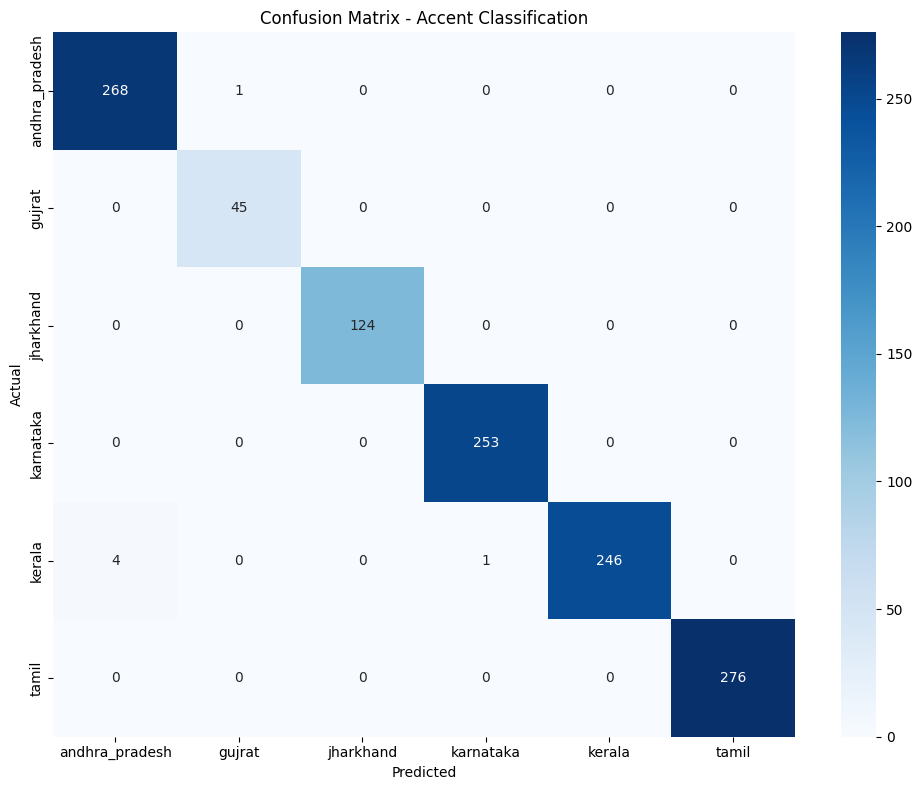

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(ytrue, ypred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Accent Classification')
plt.tight_layout()
plt.show()


# **HUBert**

In [ ]:
!pip install --quiet datasets==3.6.0 librosa scikit-learn transformers torch torchaudio soundfile


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import HubertModel, Wav2Vec2FeatureExtractor
from sklearn.metrics import accuracy_score, classification_report
import librosa
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [ ]:
TARGET_SR = 16000

# Load dataset
raw_ds = load_dataset("DarshanaS/IndicAccentDb")
full = raw_ds["train"]
label_names = full.features["label"].names
n_classes = len(label_names)

print("Labels:", label_names)
print("Number of classes:", n_classes)

# Create splits
splits = full.train_test_split(test_size=0.15, stratify_by_column="label", seed=42)
test_hf = splits["test"]
train_val = splits["train"].train_test_split(test_size=0.15, stratify_by_column="label", seed=42)
train_hf = train_val["train"]
val_hf = train_val["test"]

print("Train/Val/Test sizes:", len(train_hf), len(val_hf), len(test_hf))


Labels: ['andhra_pradesh', 'gujrat', 'jharkhand', 'karnataka', 'kerala', 'tamil']
Number of classes: 6
Train/Val/Test sizes: 5863 1035 1218


In [ ]:
# Load HuBERT-base model (12 transformer layers)
model_name = "facebook/hubert-base-ls960"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
hubert_model = HubertModel.from_pretrained(
    model_name,
    output_hidden_states=True  # Extract all layer outputs
).to(DEVICE)
hubert_model.eval()

print(f"HuBERT model loaded: {model_name}")
print(f"Number of layers: {hubert_model.config.num_hidden_layers}")
print(f"Hidden size: {hubert_model.config.hidden_size}")


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

HuBERT model loaded: facebook/hubert-base-ls960
Number of layers: 12
Hidden size: 768


In [ ]:
class HuBERTDataset(Dataset):
    def __init__(self, hf_dataset, target_sr=TARGET_SR):
        self.ds = hf_dataset
        self.target_sr = target_sr

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        audio = row["audio"]

        # Get audio array
        wav = np.array(audio["array"], dtype=np.float32)
        sr = audio["sampling_rate"]

        # Convert to mono if stereo
        if wav.ndim > 1:
            wav = wav.mean(axis=0)

        # Resample if needed
        if sr != self.target_sr:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=self.target_sr)

        label = int(row["label"])
        return wav, label


In [ ]:
def custom_collate(batch):
    """Custom collate function for variable-length audio"""
    wavs, labels = zip(*batch)
    return list(wavs), torch.LongTensor(labels)

def extract_hubert_embeddings_all_layers(dataloader, hubert_model, feature_extractor):
    """Extract embeddings from all HuBERT layers"""
    all_layer_embeddings = []
    all_labels = []

    num_layers = hubert_model.config.num_hidden_layers + 1  # +1 for CNN output

    with torch.no_grad():
        for wavs, labels in tqdm(dataloader, desc="Extracting embeddings"):
            # Process each audio in batch
            for wav, label in zip(wavs, labels):
                # Prepare input
                inputs = feature_extractor(
                    wav if isinstance(wav, np.ndarray) else wav.numpy(),
                    sampling_rate=TARGET_SR,
                    return_tensors="pt",
                    padding=True
                ).to(DEVICE)

                # Get outputs from all layers
                outputs = hubert_model(**inputs)
                hidden_states = outputs.hidden_states  # Tuple of (num_layers+1) tensors

                # Extract mean pooling from each layer
                layer_features = []
                for layer_idx in range(num_layers):
                    layer_output = hidden_states[layer_idx]  # (1, time, hidden_size)
                    pooled = layer_output.mean(dim=1).squeeze(0).cpu().numpy()  # (hidden_size,)
                    layer_features.append(pooled)

                all_layer_embeddings.append(layer_features)
                all_labels.append(label.item())

    return all_layer_embeddings, all_labels

# Create dataloaders with custom collate function
train_ds = HuBERTDataset(train_hf)
val_ds = HuBERTDataset(val_hf)
test_ds = HuBERTDataset(test_hf)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=False, collate_fn=custom_collate)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=custom_collate)

print("Extracting embeddings from train set...")
train_embeddings, train_labels = extract_hubert_embeddings_all_layers(train_loader, hubert_model, feature_extractor)

print("Extracting embeddings from validation set...")
val_embeddings, val_labels = extract_hubert_embeddings_all_layers(val_loader, hubert_model, feature_extractor)

print("Extracting embeddings from test set...")
test_embeddings, test_labels = extract_hubert_embeddings_all_layers(test_loader, hubert_model, feature_extractor)

print(f"Embeddings extracted! Shape per sample: {len(train_embeddings[0])} layers x {train_embeddings[0][0].shape[0]} features")


Extracting embeddings from train set...


Extracting embeddings: 100%|██████████| 733/733 [2:06:26<00:00, 10.35s/it]


Extracting embeddings from validation set...


Extracting embeddings: 100%|██████████| 130/130 [22:21<00:00, 10.32s/it]


Extracting embeddings from test set...


Extracting embeddings: 100%|██████████| 153/153 [26:18<00:00, 10.31s/it]

Embeddings extracted! Shape per sample: 13 layers x 768 features


In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.fc(x)

def train_classifier_for_layer(train_emb, train_labs, val_emb, val_labs,
                                layer_idx, n_classes, epochs=15):
    """Train a classifier for a specific layer"""
    # Extract embeddings for this layer
    X_train = torch.FloatTensor(np.array([emb[layer_idx] for emb in train_emb]))
    y_train = torch.LongTensor(train_labs)
    X_val = torch.FloatTensor(np.array([emb[layer_idx] for emb in val_emb]))
    y_val = torch.LongTensor(val_labs)

    # Create dataloaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    model = SimpleClassifier(X_train.shape[1], n_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_dl:
                x_batch = x_batch.to(DEVICE)
                outputs = model(x_batch)
                preds = outputs.argmax(dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_true.extend(y_batch.numpy())

        val_acc = accuracy_score(val_true, val_preds)
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return model, best_val_acc


In [ ]:
num_layers = len(train_embeddings[0])
layer_results = {}

print(f"\n{'='*60}")
print("LAYER-WISE ANALYSIS - Training classifiers for each layer")
print(f"{'='*60}\n")

for layer_idx in range(num_layers):
    print(f"Training classifier for Layer {layer_idx}...")
    model, val_acc = train_classifier_for_layer(
        train_embeddings, train_labels,
        val_embeddings, val_labels,
        layer_idx, n_classes, epochs=15
    )

    # Test evaluation
    X_test = torch.FloatTensor(np.array([emb[layer_idx] for emb in test_embeddings])).to(DEVICE)
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test).argmax(dim=1).cpu().numpy()

    test_acc = accuracy_score(test_labels, test_preds)

    layer_results[layer_idx] = {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'model': model,
        'predictions': test_preds
    }

    print(f"  Layer {layer_idx}: Val Acc = {val_acc:.4f}, Test Acc = {test_acc:.4f}\n")

# Save results
torch.save(layer_results, "hubert_layer_analysis.pth")
print("Layer-wise results saved!")



LAYER-WISE ANALYSIS - Training classifiers for each layer

Training classifier for Layer 0...
  Layer 0: Val Acc = 0.9971, Test Acc = 0.9959

Training classifier for Layer 1...
  Layer 1: Val Acc = 0.9981, Test Acc = 0.9967

Training classifier for Layer 2...
  Layer 2: Val Acc = 0.9990, Test Acc = 0.9967

Training classifier for Layer 3...
  Layer 3: Val Acc = 0.9981, Test Acc = 0.9975

Training classifier for Layer 4...
  Layer 4: Val Acc = 0.9990, Test Acc = 0.9975

Training classifier for Layer 5...
  Layer 5: Val Acc = 0.9990, Test Acc = 0.9951

Training classifier for Layer 6...
  Layer 6: Val Acc = 0.9981, Test Acc = 0.9943

Training classifier for Layer 7...
  Layer 7: Val Acc = 0.9971, Test Acc = 0.9975

Training classifier for Layer 8...
  Layer 8: Val Acc = 0.9961, Test Acc = 0.9951

Training classifier for Layer 9...
  Layer 9: Val Acc = 0.9952, Test Acc = 0.9910

Training classifier for Layer 10...
  Layer 10: Val Acc = 0.9952, Test Acc = 0.9893

Training classifier for L

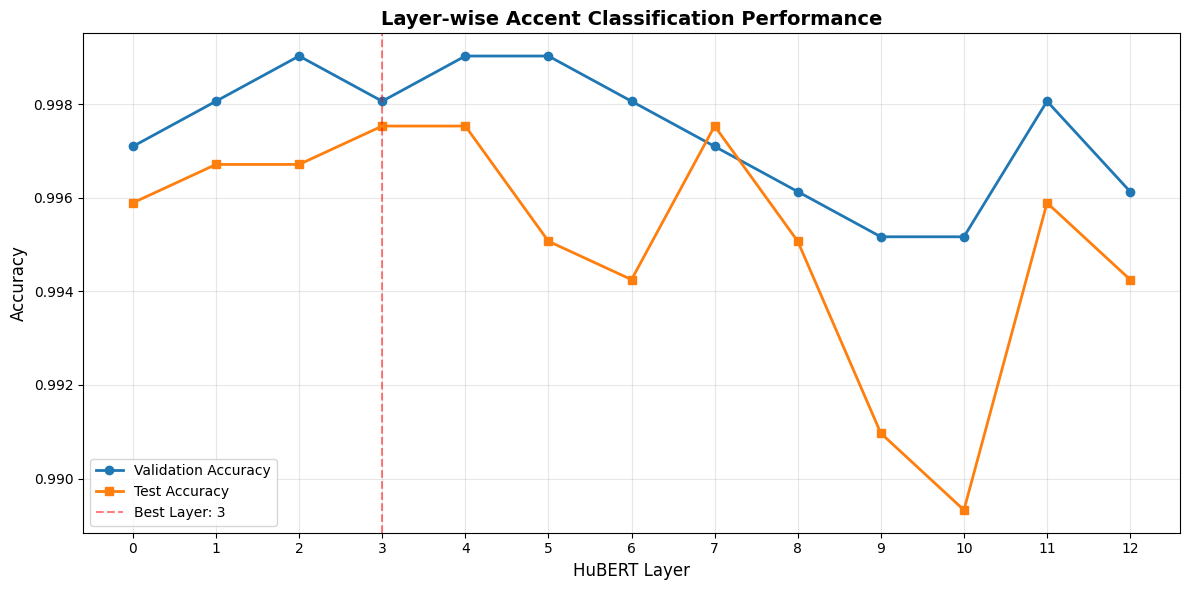


BEST LAYER FOR ACCENT CLASSIFICATION: Layer 3
Test Accuracy: 0.9975 (99.75%)

Classification Report for Best Layer:
                precision    recall  f1-score   support

andhra_pradesh       1.00      0.99      0.99       269
        gujrat       1.00      1.00      1.00        45
     jharkhand       1.00      1.00      1.00       124
     karnataka       1.00      1.00      1.00       253
        kerala       1.00      1.00      1.00       251
         tamil       1.00      1.00      1.00       276

      accuracy                           1.00      1218
     macro avg       1.00      1.00      1.00      1218
  weighted avg       1.00      1.00      1.00      1218



In [ ]:
import matplotlib.pyplot as plt

# Extract accuracies
layers = list(layer_results.keys())
val_accs = [layer_results[l]['val_acc'] for l in layers]
test_accs = [layer_results[l]['test_acc'] for l in layers]

# Find best layer
best_layer = max(layer_results.keys(), key=lambda l: layer_results[l]['test_acc'])
best_test_acc = layer_results[best_layer]['test_acc']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(layers, val_accs, marker='o', label='Validation Accuracy', linewidth=2)
plt.plot(layers, test_accs, marker='s', label='Test Accuracy', linewidth=2)
plt.axvline(x=best_layer, color='red', linestyle='--', alpha=0.5,
            label=f'Best Layer: {best_layer}')
plt.xlabel('HuBERT Layer', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Layer-wise Accent Classification Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(layers)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"BEST LAYER FOR ACCENT CLASSIFICATION: Layer {best_layer}")
print(f"Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"{'='*60}\n")

# Detailed report for best layer
print("Classification Report for Best Layer:")
print(classification_report(test_labels, layer_results[best_layer]['predictions'],
                           target_names=label_names))
